In [1]:
import pandas as pd
import pickle
import seaborn as sns
from sklearn.cluster import KMeans #聚类模块
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib

In [2]:
df_complexity = pd.read_pickle('./raf/output/df_complexity.pkl.zstd', compression='zstd')

In [17]:
infos = [
    {
        'name': chr(9311 + 1) + ' WS',
        "OS": 'win-15s',
        "idx": [9487,12077,12381]
    },
    {
        'name': chr(9311 + 2) + 'MBP',
        "OS": 'mac-15s',
        "idx": [9487, 12383, 1145]
    },
    # {
    #     'name': chr(9311 + 3),
    #     "OS": 'linux',
    #     "idx": [5272,18693]
    # },
    {
        'name': chr(9311 + 4) + 'NUC',
        "OS": 'nuc9',
        "idx": [5272, 9487]
    },
    # {
    #     'name': chr(9311 + 2),
    #     "OS": 'nuc9',
    #     "idx": [9487, 12383, 1145]
    # },
    # {
    #     'name': chr(9311 + 3),
    #     "OS": 'mac-15s',
    #     "idx": [9487, 12383, 1145]
    # }
]

In [18]:
dfs = []
for x in infos:
    OS = x['OS']
    idx = x['idx']
    df = pd.read_pickle(f'./performance/output/df_performance-{OS}-0924.pkl.zstd', compression='zstd')
    df_webgl = df[~df.webgl_time.isna()].copy()
    print(df_webgl[df_webgl['frames_count'].apply(lambda x: len(x)) == 2])
    df_webgl.loc[idx, 'frames_count'] = df_webgl.loc[idx]['frames_count'].map(lambda x: [min(x)])
    df_webgl.frames_count = df_webgl.frames_count.apply(lambda x: min(600, max(x)))
    dfs.append(df_webgl)

      status  cpu_real  cpu_full  gpu_real  gpu_full  webgl_time   
1604      Ok  0.576317  0.861717  0.576562  0.689951    0.255781  \
3280      Ok  2.212492  2.356115  0.365792  0.385714    0.125522   
5272      Ok  2.418309  2.687784  3.280816  3.486913    1.895647   
5606      Ok  0.370656  0.577769  0.327018  0.455900    0.180585   
8481      Ok  0.751085  0.821201  0.071700  0.076889    0.000708   
9106      Ok  0.727628  0.804687  0.070498  0.074335    0.000781   
9419      Ok  0.779707  0.978167  0.392318  1.521384    1.380418   
9481      Ok  0.274990  0.324616  0.011635  0.012369    0.007948   
9487      Ok  1.223590  9.967346  9.762705  9.987876    9.742641   
10024     Ok  0.546701  0.694539  0.545221  0.600178    0.059421   
12077     Ok  0.880988  0.941275  0.043501  0.056589    0.002641   
12381     Ok  1.176711  1.567105  0.158312  0.436657    0.003014   
14386     Ok  1.739991  1.919689  0.719199  0.803291    0.614700   
18841     Ok  0.792420  0.856602  0.073465  0.08

In [19]:
def plot_cdf(arr, *args, ax=None, **kwargs):
    arr = np.sort(arr)
    y = np.arange(len(arr)) / float(len(arr))
    if ax is None:
        plt.plot(arr, y, *args, **kwargs)
    else:
        ax.plot(arr, y, *args, **kwargs)

In [20]:
cmap_colors = [(0, 'tab:red'), (0.5, 'white'), (1, 'tab:green')]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('CustomMap', cmap_colors)

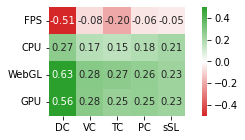

In [21]:
rows = ['frames_count', 'cpu_real', 'webgl_time', 'gpu_real']
columns = ['Draw Calls', 'Vertex Count', 'Texture Count', 'Program Count', 'Shader Length (KB)']

df = df_complexity.join(dfs[0][rows], how='inner')
df.dropna(inplace=True)

p_values = pd.DataFrame(index=rows, columns=columns, dtype=float)
r_values = pd.DataFrame(index=rows, columns=columns, dtype=float)

for col1 in rows:
    for col2 in columns:
        r_value, p_value = stats.pearsonr(df[col1], df[col2])
        r_values.loc[col1, col2] = r_value
        p_values.loc[col1, col2] = p_value
p_values_mask = p_values < 0.05

plt.figure(figsize=(6,2))
ax[i] = sns.heatmap(r_values, square=True, annot=True, cmap=cmap, fmt='.2f', center=0, vmin=-0.5, vmax=0.5)
# plt.title('Correlation r value between complexity and performance\nwith p-value >= 0.05 masked', fontsize=20, pad=20)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
ax[i].xaxis.set_ticklabels(['DC', 'VC', 'TC', 'PC', 'sSL'], rotation=0)
ax[i].yaxis.set_ticklabels(['FPS', 'CPU', 'WebGL', 'GPU'], rotation=0)
for i in range(len(r_values.index)):
    for j in range(len(r_values.columns)):
        if not p_values_mask.iloc[i, j]:
            ax[i].add_patch(plt.Rectangle((j, i), 1, 1, fill=True, lw=0, facecolor='#ccc', edgecolor='black', alpha=1, hatch='///'))
            
plt.savefig("output/heatmap-rvalue.pdf", bbox_inches='tight')
plt.savefig("output/heatmap-rvalue.png", bbox_inches='tight', dpi=300)

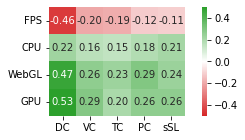

In [22]:
rows = ['frames_count', 'cpu_real', 'webgl_time', 'gpu_real']
columns = ['Draw Calls', 'Vertex Count', 'Texture Count', 'Program Count', 'Shader Length (KB)']

df = df_complexity.join(dfs[1][rows], how='inner')
df.dropna(inplace=True)

p_values = pd.DataFrame(index=rows, columns=columns, dtype=float)
r_values = pd.DataFrame(index=rows, columns=columns, dtype=float)

for col1 in rows:
    for col2 in columns:
        r_value, p_value = stats.pearsonr(df[col1], df[col2])
        r_values.loc[col1, col2] = r_value
        p_values.loc[col1, col2] = p_value
p_values_mask = p_values < 0.05

plt.figure(figsize=(6,2))
ax[i] = sns.heatmap(r_values, square=True, annot=True, cmap=cmap, fmt='.2f', center=0, vmin=-0.5, vmax=0.5)
# plt.title('Correlation r value between complexity and performance\nwith p-value >= 0.05 masked', fontsize=20, pad=20)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
ax[i].xaxis.set_ticklabels(['DC', 'VC', 'TC', 'PC', 'sSL'], rotation=0)
ax[i].yaxis.set_ticklabels(['FPS', 'CPU', 'WebGL', 'GPU'], rotation=0)
for i in range(len(r_values.index)):
    for j in range(len(r_values.columns)):
        if not p_values_mask.iloc[i, j]:
            ax[i].add_patch(plt.Rectangle((j, i), 1, 1, fill=True, lw=0, facecolor='#ccc', edgecolor='black', alpha=1, hatch='///'))
            
plt.savefig("output/heatmap-rvalue.pdf", bbox_inches='tight')
plt.savefig("output/heatmap-rvalue.png", bbox_inches='tight', dpi=300)

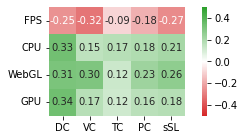

In [23]:
rows = ['frames_count', 'cpu_real', 'webgl_time', 'gpu_real']
columns = ['Draw Calls', 'Vertex Count', 'Texture Count', 'Program Count', 'Shader Length (KB)']

df = df_complexity.join(dfs[2][rows], how='inner')
df.dropna(inplace=True)

p_values = pd.DataFrame(index=rows, columns=columns, dtype=float)
r_values = pd.DataFrame(index=rows, columns=columns, dtype=float)

for col1 in rows:
    for col2 in columns:
        r_value, p_value = stats.pearsonr(df[col1], df[col2])
        r_values.loc[col1, col2] = r_value
        p_values.loc[col1, col2] = p_value
p_values_mask = p_values < 0.05

plt.figure(figsize=(6,2))
ax[i] = sns.heatmap(r_values, square=True, annot=True, cmap=cmap, fmt='.2f', center=0, vmin=-0.5, vmax=0.5)
# plt.title('Correlation r value between complexity and performance\nwith p-value >= 0.05 masked', fontsize=20, pad=20)
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')
ax[i].xaxis.set_ticklabels(['DC', 'VC', 'TC', 'PC', 'sSL'], rotation=0)
ax[i].yaxis.set_ticklabels(['FPS', 'CPU', 'WebGL', 'GPU'], rotation=0)
for i in range(len(r_values.index)):
    for j in range(len(r_values.columns)):
        if not p_values_mask.iloc[i, j]:
            ax[i].add_patch(plt.Rectangle((j, i), 1, 1, fill=True, lw=0, facecolor='#ccc', edgecolor='black', alpha=1, hatch='///'))
            
plt.savefig("output/heatmap-rvalue.pdf", bbox_inches='tight')
plt.savefig("output/heatmap-rvalue.png", bbox_inches='tight', dpi=300)

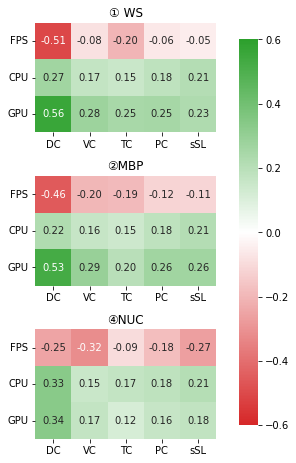

In [85]:
# plot these three graphs into one
fig, ax = plt.subplots(3, 1, figsize=(3.6 * 0.9, 8.5 * 0.9))
fig.subplots_adjust(hspace=0.4) # changes the height padding
rows = ['frames_count', 'cpu_real', 'gpu_real']
columns = ['Draw Calls', 'Vertex Count', 'Texture Count', 'Program Count', 'Shader Length (KB)']

cbar_ax = fig.add_axes([1, .15, .08, .7])

for i in range(3):
    df = df_complexity.join(dfs[i][rows], how='inner')
    df.dropna(inplace=True)

    p_values = pd.DataFrame(index=rows, columns=columns, dtype=float)
    r_values = pd.DataFrame(index=rows, columns=columns, dtype=float)

    for col1 in rows:
        for col2 in columns:
            r_value, p_value = stats.pearsonr(df[col1], df[col2])
            r_values.loc[col1, col2] = r_value
            p_values.loc[col1, col2] = p_value

    if i == 0:
        sns.heatmap(r_values, square=False, annot=True, cmap=cmap, fmt='.2f', center=0, vmin=-0.6, vmax=0.6, ax=ax[i], cbar_ax=cbar_ax)
    else:
        sns.heatmap(r_values, square=False, annot=True, cmap=cmap, fmt='.2f', center=0, vmin=-0.6, vmax=0.6, ax=ax[i], cbar=False)
    ax[i].xaxis.set_ticklabels(['DC', 'VC', 'TC', 'PC', 'sSL'], rotation=0)
    ax[i].yaxis.set_ticklabels(['FPS', 'CPU', 'GPU'], rotation=0)
    ax[i].set_title(infos[i]['name'], fontsize=12)

plt.savefig("output/heatmap-rvalue.pdf", bbox_inches='tight')

In [81]:
data = {
    'pid': ['A', 'A', 'A', 'B', 'B', 'C', 'C', 'C'],
    'ts': [1, 17, 26, 1, 2, 1, 2, 3],
    'value': [10, 15, 20, 10, 15, 20, 25, 30]
}

df = pd.DataFrame(data)

print(df)


  pid  ts  value
0   A   1     10
1   A  17     15
2   A  26     20
3   B   1     10
4   B   2     15
5   C   1     20
6   C   2     25
7   C   3     30


In [82]:
frames_df = df.sort_values(['pid','ts']).drop_duplicates() 
frames_df['delta'] = frames_df.groupby('pid')['ts'].diff()  
frames_dur_std = frames_df.groupby('pid')['delta'].std().tolist() 
frames_dur_mean = frames_df.groupby('pid')['delta'].mean().tolist() 
frames_dur_highest = frames_df.groupby('pid')['delta'].quantile(0.9).tolist()

In [83]:
frames_dur_highest

[15.3, 1.0, 1.0]

In [84]:
frames_df

,pid,ts,value,delta
0,A,1,10,NaN
1,A,17,15,16.0
2,A,26,20,9.0
3,B,1,10,NaN
4,B,2,15,1.0
5,C,1,20,NaN
6,C,2,25,1.0
7,C,3,30,1.0
